In [1]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os 
import csv
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter1d

: 

# Device Setup

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Optionally, you can print more details about the GPU if available
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs available: {torch.cuda.device_count()}")

Using device: cuda
GPU Name: Tesla T4
Number of GPUs available: 1


# Data Preparation
Still need to create binary label!


In [5]:
def label_normaliser(label):
    total = sum(label)
    if total == 0:
        return [0 for _ in label]  # Return an array of zeros if total is zero
    else:
        return [value / total for value in label]
    
def normalize_spectra_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (np.ndarray): 1D array representing the spectrum.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)
    
    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum
    
    # Normalize the spectrum by its area
    normalized_spectrum = spectrum / area
    
    return normalized_spectrum


def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

def label_converter(label):
    '''
    Converts the encoded label lists into a readable format

    '''
    CEL_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx') 
    label_dict = get_label_dict(CEL_path)
    label_dict.append('alkane')
    fg_counts = []
    fg_count = "" 

    for i, e in enumerate(label):
        if pd.isna(e):
            e = 0
        if e != 0.0:
            fg_count = f'{e:.2f}  {label_dict[i]}'
            fg_counts.append(fg_count)

    return fg_counts


def apply_horizontal_shift(spectrum, max_shift):
    '''
    Applies a random horizontal shift to the entire spectrum sequence.
    Args:
        spectrum
        max_shift: maximum number of indices by which the data can shift (set to zero for no shift allowed)
    Returns:
        shifted_spectrum
    '''
    shift = random.randint(-max_shift, max_shift)
    # Create an array of zeros with the same length as the original spectrum
    shifted_spectrum = np.zeros_like(spectrum)

    if shift > 0:
        # Shift to the right
        shifted_spectrum[shift:] = spectrum[:-shift]
    elif shift < 0:
        # Shift to the left
        shifted_spectrum[:shift] = spectrum[-shift:]
    else:
        # No shift, return the original spectrum
        shifted_spectrum = spectrum.copy()

    shifted_spectrum = shifted_spectrum[:len(spectrum)]
    return shifted_spectrum

def gaussian_broadening(spectrum, sigma_sigma):
    '''
    Applies random Gaussian broadening to spectra 
    Args:
        spectrum = input (unbroadened spectrum)
        sigma_sigma = the standard deviation for the distrobution determining sigma for gaussian kernal

    returns:
        broadened_spectrum: spectrum with peak broadening 
    
    '''
    sigma = np.abs(np.random.normal(0, sigma_sigma)) # half normal distribution centered at zero
    convolved_spectrum = gaussian_filter1d(spectrum,sigma)
    return convolved_spectrum

#Create a custom dataset class
class SpectraDataset(Dataset):
    def __init__(self, spectra, labels):
        self.spectra = spectra
        self.labels = labels

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        return self.spectra[idx], self.labels[idx]

def create_uniform_energy_grid(start_energy, end_energy, increment=0.1):
    """
    Create a uniform energy grid with a fixed increment.
    
    Args:
        start_energy: Starting energy value.
        end_energy: Ending energy value.
        increment: Energy increment (default is 0.1 eV).
    
    Returns:
        energy_range: Uniform energy grid as a NumPy array.
    """
    return np.arange(start_energy, end_energy + increment, increment)

In [6]:
def get_label_dict(path_to_file):
    '''
    Extract the list of functional groups
    '''
    spreadsheet_f = pd.ExcelFile(path_to_file)
    df_f = pd.read_excel(spreadsheet_f)
    return list(df_f['Functional groups'])

data_path = Path("../data/experimental_data")
CEL_FG_path = os.path.join(data_path, 'cellulose (CEL)', 'CEL_FG.xlsx')
FG_list = get_label_dict(CEL_FG_path)
FG_list.append('alkane')

In [33]:
max_shift = 0  
energy_step = 0.1 
max_shift_index = int(max_shift / energy_step) # max_shift converted to index

valence_range = 0 # valence region is already excluded during data generation
valence_region_index = int(valence_range / energy_step) 

base_data_dir = Path('../data/synthetic_data_hard_final')

spectra_dir = base_data_dir / 'synthetic_spectra'
labels_dir = base_data_dir / 'synthetic_labels'


print(f"Loading spectra from: {spectra_dir}")
# Using pathlib's glob to find .npy files and sort them numerically
all_spectra_paths = sorted(
    spectra_dir.glob('spectrum_*.npy'),
    key=lambda x: int(x.stem.split('_')[1]) # Extract the number N from 'spectrum_N'
)

if not all_spectra_paths:
    raise FileNotFoundError(f"No spectrum files found in {spectra_dir}")

print(f"Found {len(all_spectra_paths)} spectrum files. Processing...")
processed_spectrum_list = []
for i, spectra_path in enumerate(all_spectra_paths):
    # Load spectrum directly using np.load
    spectrum = np.load(spectra_path)

    # Apply processing steps directly to the numpy array
    shifted_spectrum = apply_horizontal_shift(spectrum, max_shift_index)
    # Slice: Ensure index is not out of bounds
    if valence_region_index >= len(shifted_spectrum):
         print(f"Warning: valence_region_index ({valence_region_index}) is too large for spectrum {i} (length {len(shifted_spectrum)}). Skipping slicing.")
         processed_part = shifted_spectrum
    else:
         processed_part = shifted_spectrum[valence_region_index:]

    processed_part = np.maximum(processed_part, 0) # Ensure non-negative
    normalized_spectrum = normalize_spectra_by_area(processed_part) # Normalize

    # Append the processed numpy array to the list
    processed_spectrum_list.append(normalized_spectrum)

# Stack the list of 1D arrays into a 2D NumPy array (N_samples, N_features)
# Ensure all processed spectra have the same length before stacking
first_len = len(processed_spectrum_list[0])
if not all(len(s) == first_len for s in processed_spectrum_list):
    raise ValueError("Processed spectra do not all have the same length after slicing/processing.")

spectrum_array = np.stack(processed_spectrum_list, axis=0)
# Convert the final NumPy array to a PyTorch tensor
spectrum_tensor = torch.tensor(spectrum_array, dtype=torch.float32)
print(f"Processed spectra tensor shape: {spectrum_tensor.shape}")


# Load and Process Labels
print(f"Loading labels from: {labels_dir}")
all_label_paths = sorted(
    labels_dir.glob('label_*.npy'),
    key=lambda x: int(x.stem.split('_')[1]) # Extracts number from 'label_N'
)

if not all_label_paths:
    raise FileNotFoundError(f"No label files found in {labels_dir}")

# double check the number of label files matches spectrum file
if len(all_spectra_paths) != len(all_label_paths):
    raise ValueError(f"Mismatch: Found {len(all_spectra_paths)} spectra but {len(all_label_paths)} labels.")

print(f"Found {len(all_label_paths)} label files. Processing...")
label_list = []
for label_path in all_label_paths:
    # Load label directly using np.load
    label = np.load(label_path)
    label_list.append(label) # Append raw label first

# Stack this list of label arays 
label_array = np.stack(label_list, axis=0)

# Apply normalization 
print("Normalizing labels...")
normalised_label_array = np.array([label_normaliser(lbl) for lbl in label_array])

# Convert the final NumPy array to a PyTorch tensor
label_tensor = torch.tensor(normalised_label_array, dtype=torch.float32)
print(f"Processed labels tensor shape: {label_tensor.shape}")


#partition data into training and test sets
print("Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    spectrum_tensor,
    label_tensor,
    test_size=0.2,      # 20% test, 80% train
    random_state=42     # Reproducible split
)

print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

input_features = X_train.shape[1]
# Handle 1D vs 2D label tensor for output_features
output_features = y_train.shape[1] if y_train.dim() > 1 else 1

print(f"Input features: {input_features}, Output features: {output_features}")

#Create Datasets and DataLoaders 
print("Creating TensorDatasets and DataLoaders...")
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
#this batch size was good for training on nvidia Tesla T4 GPU, but alternatve setups may benefit from a smaller/larger batch size


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Data loading and preparation complete. train_loader and test_loader are ready.")

Loading spectra from: ../data/synthetic_data_hard_final/synthetic_spectra
Found 100000 spectrum files. Processing...
Processed spectra tensor shape: torch.Size([100000, 6601])
Loading labels from: ../data/synthetic_data_hard_final/synthetic_labels
Found 100000 label files. Processing...
Normalizing labels...
Processed labels tensor shape: torch.Size([100000, 40])
Splitting data into training and testing sets...
Training samples: 80000, Testing samples: 20000
Input features: 6601, Output features: 40
Creating TensorDatasets and DataLoaders...
Data loading and preparation complete. train_loader and test_loader are ready.


permanently save the test batch so it can be used in a seperate script (latent_vis)

In [10]:
test_data_dir = Path('../data/test_data_final/test_spectra')
test_labels_dir = Path('../data/test_data_final/test_labels')

# Assuming test_loader is defined and provides batches of data
test_data_list = []
test_labels_list = []

# Iterate through the test_loader
for data, labels in test_loader:
    test_data_list.append(data.cpu().numpy())  # Convert to NumPy and store
    test_labels_list.append(labels.cpu().numpy())  # Convert to NumPy and store

# Concatenate the lists into single arrays
test_data_array = np.concatenate(test_data_list, axis=0)
test_labels_array = np.concatenate(test_labels_list, axis=0)


# Save with proper filenames in the specified directories
np.save(test_data_dir / f'test_spectra_hard.npy', test_data_array)
np.save(test_labels_dir / f'test_labels_hard.npy', test_labels_array)

print(f"Test spectra saved to: {test_data_dir / f'test_spectra_labels_hard_CVAE.npy'}")
print(f"Test labels saved to: {test_labels_dir / f'test_labels_labels_hard_CVAE.npy'}")

Test spectra saved to: ../data/test_data_final/test_spectra/test_spectra_labels_hard_CVAE.npy
Test labels saved to: ../data/test_data_final/test_labels/test_labels_labels_hard_CVAE.npy


# Set Up Model

In [26]:
# orignal loss function

# Loss function (reconstruction + KL divergence)
def loss_function(recon_x, x, mu, log_var, alpha=1.0, beta=1.0):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return alpha* MSE + beta* KLD

# Loss function (reconstruction + KL divergence)
def KL_div(mu, log_var, beta =1.0):
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())  # KL divergence
    return beta* KLD

def recon_loss(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    return MSE

In [27]:
import torch
import torch.nn as nn
import numpy as np # Keep if needed elsewhere

class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, cond_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.cond_dim = cond_dim

        # Encoder 
        self.encoder_layers = nn.Sequential(
            nn.Linear(input_dim + cond_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.Dropout(0.3),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.2),
        )
        self.fc_mu_logvar = nn.Linear(256, 2 * latent_dim)

        #  Decoder
        self.decoder = nn.Sequential(
            # Input: latent_dim + cond_dim
            nn.Linear(latent_dim + cond_dim, 512), 
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 1024), 
            nn.LayerNorm(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, input_dim), # Output layer
            nn.Softplus()
        )

    # encode, reparameterize, decode, forward methods
    def encode(self, x, c):
        combined_input = torch.cat([x, c], 1)
        hidden = self.encoder_layers(combined_input)
        mu_logvar = self.fc_mu_logvar(hidden)
        mu, logvar = torch.chunk(mu_logvar, 2, dim=1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        combined_input = torch.cat([z, c], 1)
        return self.decoder(combined_input)

    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, c)
        return recon_x, mu, log_var

In [11]:


# Loss function (reconstruction + KL divergence)
def KL_div(mu, logvar, prior_var_epsilon):
    """
    Calculates the TOTAL KL divergence sum across batch and latent dimensions
    between the learned distribution N(mu, var) and a diagonal Gaussian prior N(0, prior_var_epsilon * I).
    KL( N(mu, var) || N(0, epsilon*I) )

    Args:
        mu (torch.Tensor): Mean from the encoder (batch_size, latent_dim).
        logvar (torch.Tensor): Log variance from the encoder (batch_size, latent_dim).
        prior_var_epsilon (float): The desired variance (epsilon) for the narrow prior.
                                   Must be positive.

    Returns:
        torch.Tensor: A scalar tensor containing the total KL divergence summed
                      across all samples in the batch and all latent dimensions.
    """
    if prior_var_epsilon <= 0:
        raise ValueError("Prior variance epsilon must be positive.")

    var = torch.exp(logvar) # sigma^2
    # Calculate log(epsilon) once, use log rules: log(epsilon / var) = log(epsilon) - log(var)
    # Ensure log_prior_var is calculated on the correct device
    log_prior_var = torch.log(torch.tensor(prior_var_epsilon, device=mu.device))

    # Element-wise KLD component for each latent dimension for each sample
    # 0.5 * (log(epsilon / var) + var / epsilon + mu^2 / epsilon - 1)
    kld_elements = 0.5 * (log_prior_var - logvar +
                           var / prior_var_epsilon + mu.pow(2) / prior_var_epsilon - 1)

    # Sum across all elements (batch and latent dimensions)
    KLD_sum = torch.sum(kld_elements)

    return KLD_sum

def recon_loss(recon_x, x):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    return MSE


# Loss function (reconstruction + KL divergence)
def loss_function(recon_x, x, mu, log_var, prior_var_epsilon, alpha=1.0, beta=1.0):
    MSE_sum = nn.functional.mse_loss(recon_x, x, reduction='sum') # Summed MSE

    # Calculate KLD sum using the updated function
    KLD_sum = KL_div(mu, log_var, prior_var_epsilon)

    # Total weighted loss
    total_loss = alpha * MSE_sum + beta * KLD_sum
    return total_loss


# Training

Continue training existing model

In [24]:
model_path = Path("/home/issa/new_project_clone/local_models/CVAE1d(0.96latentvar).pth")
input_dim = 6601
cond_dim = 40

latent_dim = 1


# Initialize model
model = CVAE(input_dim, latent_dim, cond_dim).to(device)

# Load the trained model
model.load_state_dict(torch.load(model_path))

training_loss_values = []
testing_loss_values = []
testing_KLD_values = []
test_recon_values = []
actual_epoch = 0 

Train new model

In [34]:
latent_dim = 1
model = CVAE(input_dim, latent_dim, cond_dim).to(device)
# Create a list to store loss values
training_loss_values = []
testing_loss_values = []
testing_KLD_values = []
test_recon_values = []
actual_epoch = 0 

prior_std = 1
prior_epsilon = prior_std**2


print(prior_epsilon)

1


In [36]:

# Configure schedulers
beta_start = 0 # Start stronger to prevent early KLD explosion
beta_end = 3.5e-3  # Gradually relax regularization
warmup_epochs = 40 #20  # Ramp up beta over this period

optimizer = torch.optim.Adam(model.parameters(), lr= 5e-04) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      mode='min',
                                                      factor=0.5,
                                                      patience=10,
                                                      verbose=True,
                                                      min_lr=1e-6)


torch.manual_seed(42)

# Set the number of epochs
epochs = 600

# Configure early stopping parameters
best_rec_loss = np.inf
no_improve_epochs = 0
patience = 20  # Number of epochs to wait for improvement


# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # Track loss for the entire epoch
    actual_epoch += 1 

    if actual_epoch < warmup_epochs:
        progress = actual_epoch / warmup_epochs
        # Linear interpolation: beta = start * (1 - progress) + end * progress
        beta = beta_start * (1.0 - progress) + beta_end * progress
    else:
        # Once schedule duration is reached, stay at beta_end
        beta = beta_end
    
   
    # Iterate over batches
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Move data to the correct device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X_batch, y_batch)
        loss  = loss_function(recon_batch, X_batch, mu, log_var, prior_epsilon, beta=beta)


        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss /= len(train_loader.dataset)
    training_loss_values.append(epoch_loss)


    # Testing loop
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    KLD_loss = 0 
    rec_loss =0
    total_test_samples = 0
    log_var_total = 0.0  # For latent collapse check
    mu_norm_total = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to the correct device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            batch_size = X_batch.size(0)
            total_test_samples += batch_size
    
            # Forward pass
            recon_test, mu_test, log_var_test = model(X_batch, y_batch)

            test_loss +=  loss_function(recon_test, X_batch, mu_test, log_var_test, prior_epsilon, beta=beta).item()
            KLD_loss += KL_div(mu_test, log_var_test, prior_epsilon).item() #no beta included in calculation
            rec_loss += recon_loss(recon_test, X_batch).item()

            # Accumulate log_var for latent variance
            log_var_total += torch.sum(log_var_test.exp()).item()
            mu_norm_total += torch.sum(torch.norm(mu_test, p=2, dim=1)).item()

    
        # Average per sample
        test_loss /= total_test_samples
        KLD_loss /= total_test_samples
        rec_loss /= total_test_samples
        
    
        latent_var = log_var_total / (total_test_samples * latent_dim)  # Average latent variance
        avg_mu_norm = mu_norm_total / total_test_samples

        if latent_var < 0.05 and epoch > 100:
            print("Latent collapse detected - stopping!")
            break

        KLD_ratio = (KLD_loss / (KLD_loss + rec_loss)) * 100
        testing_loss_values.append(test_loss)
        testing_KLD_values.append(KLD_loss)
        test_recon_values.append(rec_loss)
    
        scheduler.step(rec_loss)

        # Early stopping check after test evaluation
        if rec_loss < best_rec_loss:
            best_rec_loss = rec_loss
            no_improve_epochs = 0
            # Optional: Save best model weights
            torch.save(model.state_dict(), 'best_CVAE_{latent_dim}d.pth')
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"\nEarly stopping at epoch {actual_epoch} - no improvement for {patience} epochs")
            break

    
    current_lr = optimizer.param_groups[0]['lr'] # Get LR from optimizer
    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {epoch_loss:.3e} | Test loss: {test_loss:.3e} | Test recon_loss: {rec_loss:.3e} | test KLD: {KLD_loss:.3e}|  KLD ratio: {KLD_ratio:.1f}%| beta: {beta:.2e} | Latent Var : {latent_var: .4f} | LR: {current_lr:.2e}| mu: {avg_mu_norm:.2e}")

Epoch: 0 | Loss: 2.362e-03 | Test loss: 2.244e-03 | Test recon_loss: 2.111e-03 | test KLD: 4.096e-02|  KLD ratio: 95.1%| beta: 3.24e-03 | Latent Var :  0.9581 | LR: 5.00e-04| mu: 1.24e-01
Epoch: 1 | Loss: 2.347e-03 | Test loss: 2.369e-03 | Test recon_loss: 2.266e-03 | test KLD: 3.111e-02|  KLD ratio: 93.2%| beta: 3.32e-03 | Latent Var :  0.9597 | LR: 5.00e-04| mu: 1.06e-01
Epoch: 2 | Loss: 2.351e-03 | Test loss: 2.242e-03 | Test recon_loss: 2.131e-03 | test KLD: 3.250e-02|  KLD ratio: 93.8%| beta: 3.41e-03 | Latent Var :  0.9643 | LR: 5.00e-04| mu: 1.01e-01
Epoch: 3 | Loss: 2.339e-03 | Test loss: 2.235e-03 | Test recon_loss: 2.164e-03 | test KLD: 2.023e-02|  KLD ratio: 90.3%| beta: 3.50e-03 | Latent Var :  0.9870 | LR: 5.00e-04| mu: 7.64e-02
Epoch: 4 | Loss: 2.335e-03 | Test loss: 2.234e-03 | Test recon_loss: 2.136e-03 | test KLD: 2.782e-02|  KLD ratio: 92.9%| beta: 3.50e-03 | Latent Var :  0.9804 | LR: 5.00e-04| mu: 9.71e-02
Epoch: 5 | Loss: 2.325e-03 | Test loss: 2.216e-03 | Test rec

KeyboardInterrupt: 

70


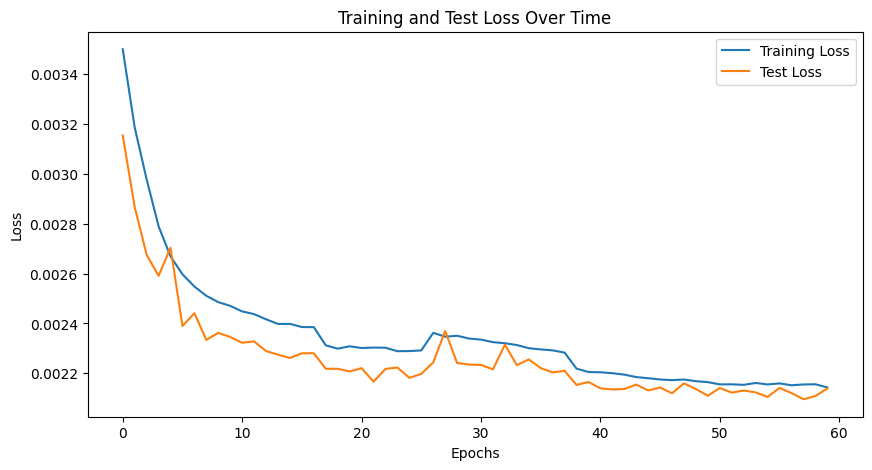

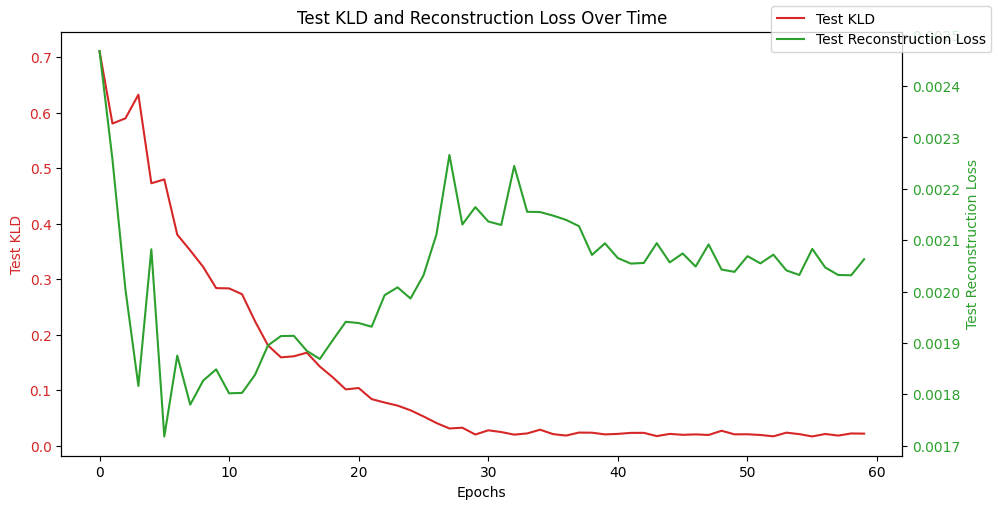

In [37]:
start = 10
print(len(training_loss_values))

# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss_values[start:], label='Training Loss')
plt.plot(testing_loss_values[start:], label='Test Loss')
plt.title('Training and Test Loss Over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot KLD loss and reconstruction loss
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Test KLD', color=color)
ax1.plot(testing_KLD_values[start:], label='Test KLD', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('Test Reconstruction Loss', color=color)  
ax2.plot(test_recon_values[start:], label='Test Reconstruction Loss', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Test KLD and Reconstruction Loss Over Time')
fig.legend()
plt.show()

In [18]:
print(len(training_loss_values))
print(len(testing_loss_values))

# Create DataFrame from your loss lists
training_metrics = {
    'epoch': list(range(len(testing_loss_values))),
    'train_loss': training_loss_values,
    'test_loss': testing_loss_values
}

# Create directories and save
report_dir = Path('../reports/cvae_results')
report_dir.mkdir(parents=True, exist_ok=True)

# Create latent dimension directory - replace LATENT_DIM with your actual value
latent_dir = report_dir / f'latent_{latent_dim}d'
latent_dir.mkdir(exist_ok=True)

# Save to CSV
pd.DataFrame(training_metrics).to_csv(latent_dir / 'training_metrics.csv', index=False)


168
168


In [40]:
# Save the model
model_path = Path("/home/issa/new_project_clone/local_models/CVAE1d(alkane).pth")
model_path.parent.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to /home/issa/new_project_clone/local_models/CVAE1d(alkane).pth


# Testing

    1. Assessing reconstruction performance

In [15]:
model_path = Path("/home/issa/new_project_clone/local_models/CVAE1d(1.4recon).pth")
latent_dim =1

data_path = Path("../data/experimental_data")
CEL_spec = os.path.join(data_path, 'cellulose (CEL)', 'cellulose') + '.xlsx'
df_f = pd.read_excel(CEL_spec, sheet_name='All')


# Initialize model
model = CVAE_Option1(input_dim, latent_dim, cond_dim).to(device)
# Load the trained model
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

CVAE_Option1(
  (encoder_layers): Sequential(
    (0): Linear(in_features=6641, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
  )
  (fc_mu_logvar): Linear(in_features=256, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=41, out_features=512, bias=True)
    (1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=512, out_features=512, bias=

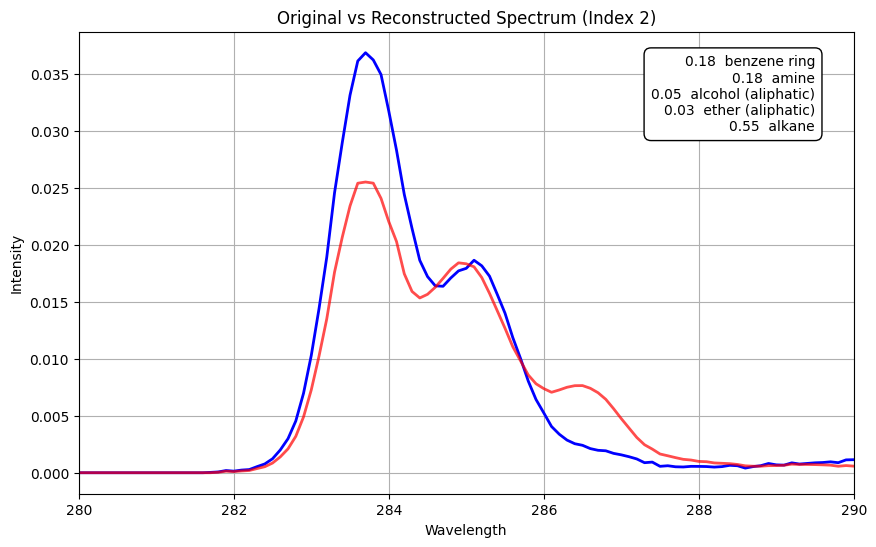

In [38]:

model.eval()
data_path = Path("../data/experimental_data")
CEL_spec = os.path.join(data_path, 'cellulose (CEL)', 'cellulose') + '.xlsx'
df_f = pd.read_excel(CEL_spec, sheet_name='All')



start_energy = 40
end_energy = 700
BE_values = create_uniform_energy_grid(start_energy, end_energy)

model.eval()  # Set the model to evaluation mode
index = 2
zoom = slice(None)
#slice(2000, 3001)



# Get the specific example
with torch.no_grad():
    X_example = test_dataset[index][0].unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    y_example = test_dataset[index][1].unsqueeze(0).to(device)  # Add batch dimension and move to GPU

    # Generate the reconstructed spectrum
    recon_example, mu, log_var = model(X_example, y_example)

# Move data back to CPU for plotting
X_example = X_example.cpu().squeeze()  # Remove batch dimension
y_example_list = y_example.cpu().squeeze().tolist()
recon_example = recon_example.cpu().squeeze().tolist()  # Remove batch dimension


plt.figure(figsize=(10, 6))
plt.plot(BE_values, X_example, color="blue", linewidth=2)
plt.plot(BE_values,normalize_spectra_by_area(recon_example),  color="red", linestyle="-", linewidth=2,alpha =0.7)

label_text = label_converter(y_example_list)

if not label_text:
    box = 'no functional groups'
else:
    box = "\n".join(label_text)
        
plt.text(0.95, 0.95, box, 
         ha='right', va='top',  # Horizontal and vertical alignment
         fontsize=10, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
         transform=plt.gca().transAxes)  # Place box in top right

plt.title(f"Original vs Reconstructed Spectrum (Index {index})")
plt.xlabel("Wavelength")
plt.ylabel("Intensity")
plt.grid(True)


# Set limits using the axes object

plt.xlim(280,290)
plt.ylim() 

plt.show()


In [20]:
def normalize_spectra_by_area(spectrum):
    """
    Normalize a 1D XPS spectrum by area (integral under the curve).
    
    Args:
        spectrum (torch.Tensor or np.ndarray): The input spectrum to normalize.
    
    Returns:
        np.ndarray: Normalized spectrum with area under the curve equal to 1.
    """
    # Convert to NumPy array if it's a PyTorch tensor
    if isinstance(spectrum, torch.Tensor):
        spectrum = spectrum.cpu().detach().numpy()  # Ensure it's on CPU and convert to NumPy

    # Compute the area under the spectrum (sum of intensities)
    area = np.sum(spectrum)

    # Avoid division by zero (if area is zero, return the original spectrum)
    if area == 0:
        return spectrum

    # Normalize the spectrum
    return spectrum / area

    2. Testing Success of conditional spectra generation

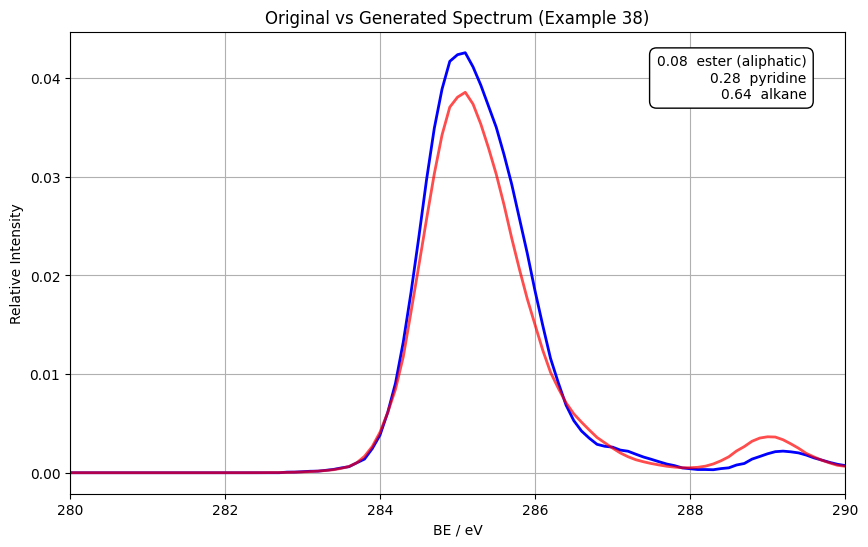

Integral of generated spectrum = 1.0265599489212036


In [39]:
index = 38
# Generate latent vector
z = torch.randn(1, latent_dim).to(device)  # Sample a random latent vector



# Get the example from test data
with torch.no_grad():
    X_example = test_dataset[index][0].unsqueeze(0).to(device)  # Add batch dimension and move to GPU
    y_example = test_dataset[index][1].unsqueeze(0).to(device)  


# Decode the latent vector to generate spectra
with torch.no_grad():  # No need to track gradients
    generated_spectra = model.decode(z, y_example)


# Move data back to CPU for plotting
X_example = X_example.cpu().squeeze()  # Remove batch dimension
y_example_list = y_example.cpu().squeeze().tolist()
generated_spectra = generated_spectra.cpu().squeeze()
generated_spectra[generated_spectra < 0] = 0


#normalised_generated_spectra = normalize_spectra_by_area(np.array(generated_spectra)).squeeze()

plt.figure(figsize=(10, 6))
plt.plot(BE_values, X_example, color="blue", linewidth=2)
plt.plot(BE_values, normalize_spectra_by_area(generated_spectra), color="red", linestyle="-", linewidth=2, alpha=0.7)
#plt.plot(normalised_generated_spectra, color="green", linestyle="-", linewidth=2, alpha=0.7)

label_text = label_converter(y_example_list)

if not label_text:
    box = 'no functional groups'
else:
    box = "\n".join(label_text)


plt.text(0.95, 0.95, box, 
         ha='right', va='top',  # Horizontal and vertical alignment
         fontsize=10, 
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),  # Box around text
         transform=plt.gca().transAxes)  # Place box in top right


plt.title(f"Original vs Generated Spectrum (Example {index})")
plt.xlabel("BE / eV")
plt.ylabel("Relative Intensity")
plt.grid(True)

# Set limits using the axes object
plt.xlim(280,290)
plt.ylim() 

plt.show()
print(f'Integral of generated spectrum = {torch.trapz(generated_spectra, dx=1)}')


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2517555058002472, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004367154557257891, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7438773512840271]
1.0322032
1.0187598
1.022578
1.0373228
1.1092137
area of synthetic spectrum: 1.0000001192092896


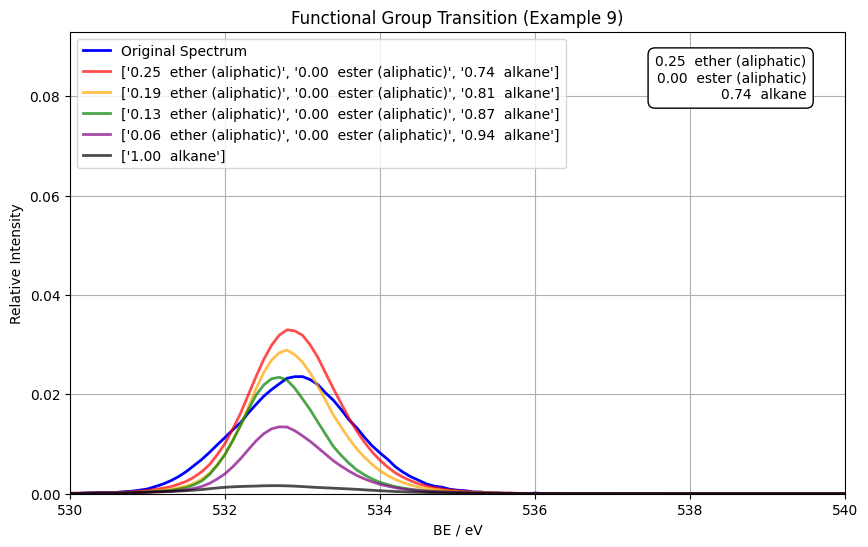

In [32]:
import torch
import numpy as np
import matplotlib.pyplot as plt

start_energy = 40
end_energy = 700
BE_values = create_uniform_energy_grid(start_energy, end_energy)

index = 9 # Example index

# Get test example
with torch.no_grad():
    X_example = test_dataset[index][0].unsqueeze(0).to(device)
    y_example = test_dataset[index][1].unsqueeze(0).to(device)

# Move to CPU
X_example = X_example.cpu().squeeze()
y_example_list = y_example.cpu().squeeze().tolist()
print(y_example_list)

# Extract components
carbon_count = y_example_list[-1]  # Last element is carbon
functional_groups = np.array(y_example_list[:-1])  # First 39 are FGs

# Get indices of non-zero FGs
fg_indices = np.where(functional_groups > 0)[0]

num_steps = 5
generated_spectra_list = []
y_interpolated_list = []

for step in range(num_steps):
    alpha = step / (num_steps - 1)
    
    # Copy and modify FGs
    y_interpolated = functional_groups.copy()
    
    # Key Fix 1: Decrease FGs by (1-alpha) instead of scaling with alpha
    y_interpolated[fg_indices] *= (1 - alpha)
    
    # Key Fix 2: Calculate new carbon to maintain sum=1
    new_carbon = 1 - y_interpolated.sum()
    y_interpolated = np.append(y_interpolated, new_carbon)
    
    # Generate spectrum
    y_tensor = torch.tensor(y_interpolated, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)*0
        generated_spectrum = model.decode(z, y_tensor).cpu().squeeze()
    
    generated_spectrum = generated_spectrum.cpu().numpy()
    
    print(sum(generated_spectrum))
    generated_spectrum = generated_spectrum/ sum(generated_spectrum)
    

    generated_spectra_list.append(generated_spectrum)
    y_interpolated_list.append(y_interpolated)


plt.figure(figsize=(10,6))
plt.plot(BE_values, X_example, color="blue", linewidth=2, label="Original Spectrum")
print(f'area of synthetic spectrum: {sum(X_example)}')


colors = ["red", "orange", "green", "purple", "black"]
for i, spectrum in enumerate(generated_spectra_list):

    interpolated_label = y_interpolated_list[i]
    interpolated_label_text = label_converter(interpolated_label)

    plt.plot(BE_values, spectrum, 
             linestyle="-", linewidth=2, alpha=0.7, 
             color=colors[i], label=f"{interpolated_label_text}")

plt.xlabel("BE / eV")
plt.ylabel("Relative Intensity")
plt.title(f"Functional Group Transition (Example {index})")
plt.legend()
plt.grid(True)
plt.xlim(530,540)
plt.ylim(0)

# Add label information
label_text = label_converter(y_example_list)
plt.text(0.95, 0.95, "\n".join(label_text), 
         ha='right', va='top', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
         transform=plt.gca().transAxes)

plt.show()

In [25]:
total_c = sum(generated_spectra[280:310])
total_n = sum(generated_spectra[390:415])
total_o = sum(generated_spectra[520:540])

total_sum = total_c + total_n + total_o
print(total_c/total_sum, total_n/total_sum, total_o/total_sum)


tensor(0.4154) tensor(0.3249) tensor(0.2597)


In [96]:
from sklearn.metrics import mean_squared_error

def test_extrapolation(model, extrapolated_labels, device):
    """
    Tests the extrapolation ability of the trained model by generating spectra 
    for unseen labels and visualizing the results.
    
    Args:
    - model: The trained model (e.g., CVAE).
    - extrapolated_labels: The new labels that are out-of-distribution or unseen during training.
    - device: The device (CPU or GPU) where the model is located.
    """
    
    model.eval()  # Set the model to evaluation mode

    # List to store generated spectra for further comparison
    generated_spectra = []
    real_spectra = []

    with torch.no_grad():  # Disable gradient computation for inference
        for label in extrapolated_labels:
            # Convert label to tensor and move it to the correct device
            label_tensor = torch.tensor(label, dtype=torch.float32).unsqueeze(0).to(device)

            # Generate spectrum using the trained model
            generated_spectrum, _, _ = model.generate(label_tensor)
            generated_spectra.append(generated_spectrum.cpu().numpy().flatten())
            
            # Real spectra could be pre-loaded from a dataset for comparison, here it assumes you have a real spectrum
            real_spectrum = load_real_spectrum(label)  # Replace with your function to get real spectra
            real_spectra.append(real_spectrum)

    # Convert lists to numpy arrays
    generated_spectra = np.array(generated_spectra)
    real_spectra = np.array(real_spectra)

    # Visualize the generated spectra
    for idx, (gen_spectrum, real_spectrum) in enumerate(zip(generated_spectra, real_spectra)):
        plt.figure(figsize=(10, 6))
        plt.plot(gen_spectrum, label='Generated Spectrum', color='b')
        plt.plot(real_spectrum, label='Real Spectrum', color='r', linestyle='--')
        plt.title(f"Extrapolation Test: Label {extrapolated_labels[idx]}")
        plt.xlabel('Energy (eV)')
        plt.ylabel('Intensity')
        plt.legend()
        plt.show()

    # Calculate MSE between generated and real spectra
    mse_values = []
    for gen_spectrum, real_spectrum in zip(generated_spectra, real_spectra):
        mse = mean_squared_error(real_spectrum, gen_spectrum)
        mse_values.append(mse)

    print("MSE for each extrapolated test case:")
    for idx, mse in enumerate(mse_values):
        print(f"Label {extrapolated_labels[idx]}: MSE = {mse}")

    # Optional: Calculate KLD between generated and real spectra if applicable
    # (you can also check the KLD per spectrum, if useful)
    kld_values = []
    for gen_spectrum, real_spectrum in zip(generated_spectra, real_spectra):
        kld = calculate_kld(real_spectrum, gen_spectrum)
        kld_values.append(kld)

    print("KLD for each extrapolated test case:")
    for idx, kld in enumerate(kld_values):
        print(f"Label {extrapolated_labels[idx]}: KLD = {kld}")

def load_real_spectrum(label):
    """
    Placeholder function to load real spectrum data for comparison.
    Replace with actual data fetching logic as needed.
    """
    # Assuming the real spectra are stored in a dictionary or other structure
    # Replace with actual lookup or loading of real spectra based on label
    return np.random.random(100)  # Example placeholder

def calculate_kld(p, q):
    """
    Calculate the Kullback-Leibler divergence between two distributions.
    p: True distribution (real spectrum)
    q: Approximate distribution (generated spectrum)
    """
    # Add a small epsilon to avoid log(0) issues
    epsilon = 1e-10
    p = np.array(p) + epsilon
    q = np.array(q) + epsilon
    return np.sum(p * np.log(p / q))

# Example usage:
extrapolated_labels = [1.5, 2.0, 2.5]  # Example extrapolated labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming you have a trained model, pass it to the function
test_extrapolation(model, extrapolated_labels, device)

AttributeError: 'FixedCVAE' object has no attribute 'generate'

    3. Visualising latent space

Converting to numpy arrays...
Latent vectors shape: (10000, 2)
Labels shape: (10000, 40)
Using label column index -1 for coloring.
Plotting...


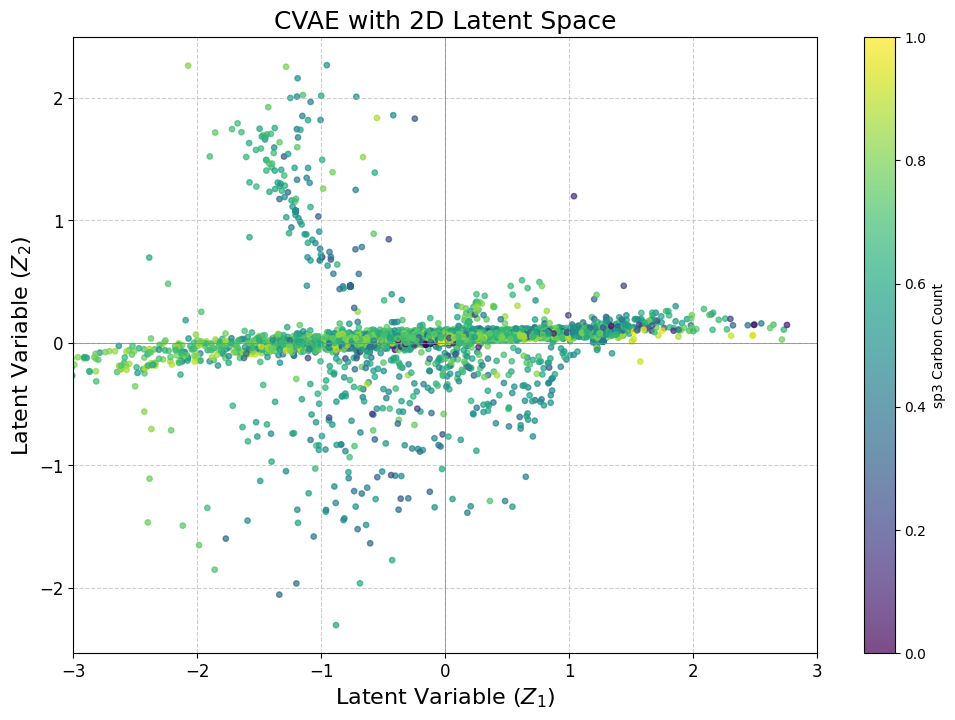

In [139]:
# Collect latent vectors and labels
latent_vectors = []
labels = []
# Use a DataLoader for efficient batching
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Collecting latent vectors...")
for batch in test_loader:
    # Ensure batch is a tuple/list containing inputs and labels
    # Adjust indexing if your dataset returns items differently
    X, y = batch[0], batch[1] # Assuming dataset returns (X, y)
    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        # Make sure model.encode exists and returns mu, log_var
        # Or adapt if your model structure is different (e.g., model(X, y) returns them)
        try:
             mu, log_var = model.encode(X, y)
        except AttributeError:
             # Fallback if encode is part of the main forward pass
             _, mu, log_var = model(X, y) # Adapt as needed

        z = mu  # Use mean for visualization

    # ** Important Check **
    if z.shape[1] != 2:
        raise ValueError(f"Latent space dimension is {z.shape[1]}, not 2D. Direct plotting requires 2D latent space.")

    latent_vectors.append(z.cpu().numpy())
    labels.append(y.cpu().numpy())

print("Converting to numpy arrays...")
# Convert lists of arrays into single numpy arrays
latent_vectors = np.concatenate(latent_vectors, axis=0) # Use concatenate
labels = np.concatenate(labels, axis=0)         # Use concatenate

# --- Check shapes ---
print(f"Latent vectors shape: {latent_vectors.shape}") # Should be (n_samples, 2)
print(f"Labels shape: {labels.shape}")
# -------------------

# Select ONE feature from labels for coloring
# Ensure the index [-1] corresponds to your sp3 counts
if labels.shape[1] > 0:
    sp3_counts = labels[:, -1]
    print(f"Using label column index {-1} for coloring.")
else:
    print("Warning: No labels found for coloring.")
    sp3_counts = None # No color if no labels

# --- REMOVED t-SNE Section ---
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# latent_2d = tsne.fit_transform(latent_vectors)
# ---------------------------

print("Plotting...")
# Plot the ORIGINAL 2D latent space
plt.figure(figsize=(12, 8))
scatter_kwargs = {
    'x': latent_vectors[:, 0],
    'y': latent_vectors[:, 1],
    'alpha': 0.7,
    's': 15
}
if sp3_counts is not None:
    scatter_kwargs['c'] = sp3_counts
    scatter_kwargs['cmap'] = 'viridis'

sc = plt.scatter(**scatter_kwargs)

if sp3_counts is not None:
    plt.colorbar(sc, label='sp3 Carbon Count') # Adjust label as needed

plt.title('CVAE with 2D Latent Space', fontsize = 18) # Updated title
plt.xlabel('Latent Variable ($Z_1$)', fontsize = 16) # Updated label
plt.ylabel('Latent Variable ($Z_2$)', fontsize = 16) # Updated label
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-3,3)
plt.axhline(0, color='grey', lw=0.5)
plt.axvline(0, color='grey', lw=0.5)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('2d_latent', dpi=600, bbox_inches='tight')
plt.show()

In [34]:
def thousands_formatter(x, pos):
    'Formats tick value x (e.g., 3000) into scaled string (e.g., "3")'
    # Divide by 1000 and format as an integer (or float if needed)
    return f'{x / 1000:.0f}'
    # Use ':.1f' for one decimal place: f'{x / 1000:.1f}'

Converting to numpy arrays...
Latent values shape: (20000,)
Labels shape: (20000, 40)
Using label column 'sp3 Carbon Count' (index -1) for plots.
Plotting: Distribution with thicker, jittered sample bar


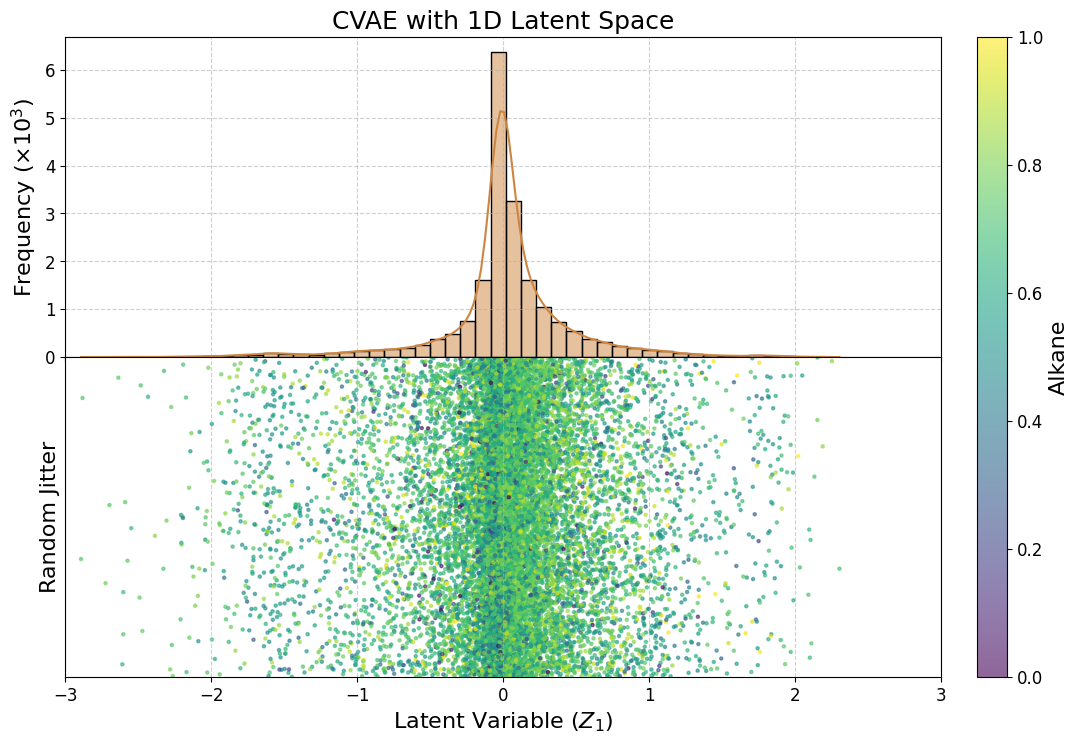

In [35]:
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # For density plots
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FuncFormatter # Import the formatter

# Collect latent vectors and labels
latent_values = [] # Store the single latent value
labels_list = [] # Use a list for labels as well
# Use a DataLoader
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

desired_xmin = -3.0  # EXAMPLE: Replace with your desired minimum
desired_xmax = 3.0   # EXAMPLE: Replace with your desired maximum

print("Collecting 1D latent vectors...")
for batch in test_loader:
    # Ensure batch is a tuple/list containing inputs and labels
    # Adjust indexing if your dataset returns items differently
    # Handle cases where dataset might return more than just X, y
    if len(batch) >= 2:
        X, y = batch[0], batch[1] # Assuming dataset returns (X, y, ...)
    else:
        # Handle datasets that might only return X (less likely for CVAE)
        # Or raise an error if labels are expected but missing
        raise ValueError("Dataset did not yield expected (X, y) pairs.")

    X, y = X.to(device), y.to(device)

    with torch.no_grad():
        # Get latent mean (mu)
        try:
             mu, log_var = model.encode(X, y)
        except AttributeError:
             # Fallback if encode is part of the main forward pass
             _, mu, log_var = model(X, y) # Adapt as needed

        # ** Important Check **
        if mu.shape[1] != 1:
            raise ValueError(f"Latent space dimension is {mu.shape[1]}, not 1D.")

        latent_values.append(mu.cpu().numpy())
        labels_list.append(y.cpu().numpy())

print("Converting to numpy arrays...")
# Convert lists of arrays into single numpy arrays
latent_values = np.concatenate(latent_values, axis=0).flatten() # Flatten to a 1D array
labels = np.concatenate(labels_list, axis=0)

# --- Check shapes ---
print(f"Latent values shape: {latent_values.shape}") # Should be (n_samples,)
print(f"Labels shape: {labels.shape}")
# -------------------

# --- Select ONE feature from labels for analysis/plotting ---
# Change the index based on which feature you want (e.g., sp3 count)
label_feature_index = -1 # Assuming last column is the feature of interest
label_feature_name = "sp3 Carbon Count" # CHANGE AS NEEDED

# --- Added back: Label Extraction Logic ---
selected_label = None # Initialize
if labels.ndim > 1 and labels.shape[1] > abs(label_feature_index):
    selected_label = labels[:, label_feature_index]
    print(f"Using label column '{label_feature_name}' (index {label_feature_index}) for plots.")
elif labels.ndim == 1: # Handle case where labels might be 1D already
     selected_label = labels
     print(f"Using 1D labels array for plots.")
     # Adjust label name if known, otherwise use a generic one
     # label_feature_name = "Label Value" # Example if you know it's just one label
else:
    print("Warning: Label array structure not suitable for indexing or no labels found.")
# -------------------------------------------
TITLE_SIZE = 18
LABEL_SIZE = 16
TICK_SIZE = 12
COLORBAR_LABEL = 'Alkane' # Use the desired name directly
FIGURE_TITLE = 'CVAE with 1D Latent Space'
Y_AXIS_LABEL = 'Frequency (×$10^3$)'
X_AXIS_LABEL = 'Latent Variable ($Z_1$)'
COLORMAP = 'viridis'
HIST_COLOR = 'peru'
POINT_SIZE = 5
POINT_ALPHA = 0.6
GRID_STYLE = '--'
GRID_ALPHA = 0.6
BORDER_COLOR = 'black'

# --------------------------------

# Ensure latent_values is 1D, selected_label is 1D and not None
if selected_label is not None and latent_values.ndim == 1 and selected_label.ndim == 1:
    print("Plotting: Distribution with thicker, jittered sample bar")

    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8),
                             gridspec_kw={'height_ratios': [1, 1]})

    # --- Top Plot: Histogram / KDE ---
    ax_top = axes[0]
    sns.histplot(latent_values, kde=True, bins=50, ax=ax_top, color=HIST_COLOR)
    ax_top.set_title(FIGURE_TITLE, fontsize=TITLE_SIZE) # Use main title here
    ax_top.set_ylabel(Y_AXIS_LABEL, fontsize=LABEL_SIZE)
    ax_top.grid(True, linestyle='--', alpha=0.6)
    ax_top.set_xlabel('') # Remove x-label from top plot
    ax_top.tick_params(axis='y', labelsize=TICK_SIZE) # Adjust y-tick size

    # --- Bottom Plot: Colored Sample Bar (Thicker & Jittered) ---
    ax_bottom = axes[1]
    cmap = plt.get_cmap(COLORMAP)
    if np.ptp(selected_label) > 1e-6:
        norm = Normalize(vmin=np.min(selected_label), vmax=np.max(selected_label))
    else:
        norm = Normalize(vmin=selected_label[0]-0.5, vmax=selected_label[0]+0.5)

    jitter_range = 0.2
    y_jitter = np.random.uniform(-jitter_range, jitter_range, size=latent_values.shape)

    sc = ax_bottom.scatter(latent_values, y_jitter, c=selected_label, cmap=cmap, norm=norm,
                           s=POINT_SIZE, alpha=POINT_ALPHA)
    
    # --- Bottom Plot Formatting ---
    ax_bottom.yaxis.set_visible(True) # Hide y-axis ticks/label
    ax_bottom.set_ylim(-(jitter_range + 0.1), (jitter_range + 0.1))
    # ** Add vertical grid lines to bottom plot **
    ax_bottom.grid(True, axis='x', linestyle=GRID_STYLE, alpha=GRID_ALPHA) # grid only for x-axis
    # ** Restore/Ensure Black Border Spines **
    # Remove previous lines hiding spines, ensure they are visible & black
    for side in ['left', 'right', 'top', 'bottom']:
        ax_bottom.spines[side].set_visible(True)
        ax_bottom.spines[side].set_color(BORDER_COLOR)
    
    ax_bottom.set_yticks([])
    ax_bottom.set_ylim(-(jitter_range), (jitter_range))
    ax_bottom.spines['left'].set_visible(True)
    ax_bottom.spines['top'].set_visible(True)
    ax_bottom.spines['right'].set_visible(True)
    ax_bottom.set_xlabel(X_AXIS_LABEL, fontsize=LABEL_SIZE)
    ax_bottom.set_ylabel("Random Jitter", fontsize=LABEL_SIZE) # SET Y LABEL
    ax_bottom.tick_params(axis='x', labelsize=TICK_SIZE) # Adjust x-tick size
    ax_bottom.tick_params(axis='x', labelsize=TICK_SIZE) # Adjust x-tick size

    # --- Set Shared X-Limits ---
    ax_bottom.set_xlim(desired_xmin, desired_xmax)

    # --- Manual Colorbar Placement ---
    # Adjust subplot parameters first
    # Might need smaller 'right' value if colorbar gets thicker
    fig.subplots_adjust(left=0.1, right=0.83, bottom=0.1, top=0.9, hspace=0.0) # Adjusted 'right' slightly

    bbox_top = ax_top.get_position()
    bbox_bottom = ax_bottom.get_position()
    ax_top.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))


    # --- Adjust colorbar thickness and padding ---
    colorbar_left_pad = 0.03  # Padding to the right of main plots
    colorbar_width = 0.025   # Increase this for a thicker colorbar (e.g., 0.02 -> 0.025)
    # ---------------------------------------------

    cax_left = bbox_top.x1 + colorbar_left_pad
    cax_bottom = bbox_bottom.y0
    cax_height = bbox_top.y1 - bbox_bottom.y0

    cax = fig.add_axes([cax_left, cax_bottom, colorbar_width, cax_height])

    # Draw the colorbar with updated label and font size
    cbar = fig.colorbar(sc, cax=cax, label=COLORBAR_LABEL)
    cbar.set_label(COLORBAR_LABEL, size=LABEL_SIZE) # Set label font size
    cbar.ax.tick_params(labelsize=TICK_SIZE) # Set colorbar tick size


    plt.savefig('1d_latent', dpi=900, bbox_inches='tight')
    plt.show()

In [56]:
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Collect latent vectors and labels
latent_vectors = []
labels = []
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)  # Larger batch size

for batch in test_loader:
    X, y = batch
    X, y = X.to(device), y.to(device)
    
    with torch.no_grad():
        mu, log_var = model.encode(X, y)
        z = mu  # Use mean for visualization
    
    latent_vectors.append(z.cpu().numpy())
    labels.append(y.cpu().numpy())

# Convert to numpy arrays
latent_vectors = np.vstack(latent_vectors)  # Shape: (n_samples, 4)
labels = np.vstack(labels)  # Shape: (n_samples, n_features)

# Select ONE feature for coloring (e.g., sp3 carbon count)
sp3_counts = labels[:, -1]  # Assuming last column is sp3 counts

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Plot with color mapping for sp3 counts
plt.figure(figsize=(12, 8))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                c=sp3_counts, 
                cmap='viridis', 
                alpha=0.7,
                s=15)
plt.colorbar(sc, label='sp3 Carbon Count')
plt.title('Latent Space Colored by sp3 Carbon Content')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

ValueError: n_components=2 must be between 1 and min(n_samples, n_features)=1 with svd_solver='randomized'

In [27]:
from mpl_toolkits.mplot3d import Axes3D

# 3D t-SNE
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
latent_3d = tsne.fit_transform(latent_vectors)

# 3D plot colored by sp3 counts
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], 
               c=sp3_counts, 
               cmap='viridis',
               s=15)
plt.colorbar(sc, label='sp3 Carbon Count')
plt.show()

ValueError: n_components=3 must be between 1 and min(n_samples, n_features)=2 with svd_solver='randomized'

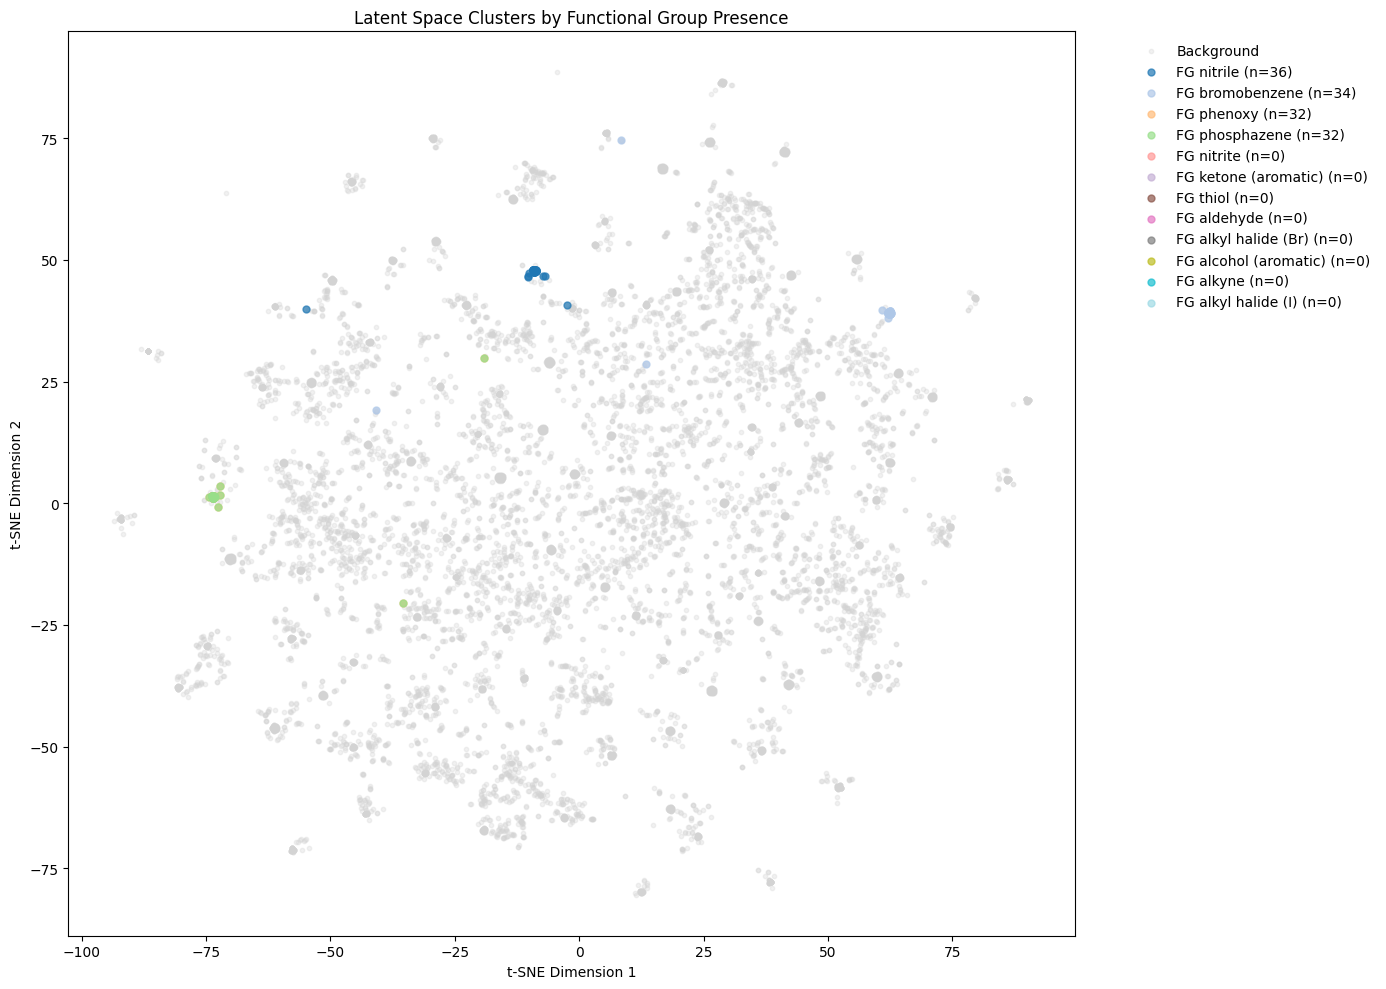

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Generate latent space visualization
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Convert continuous labels to presence/absence using thresholds
threshold = 0.25  # Adjust based on your data distribution
binary_labels = (labels > threshold).astype(int)

# Select most frequent 20 classes for visualization
class_counts = binary_labels.sum(axis=0)
selected_classes = np.argsort(-class_counts)[20:-8]  # Top 20 most frequent

# Create plot
plt.figure(figsize=(14, 10))

# Plot all points in background
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
           c='lightgrey', alpha=0.3, s=10, label='Background')

# Plot clusters for selected classes
colors = plt.cm.tab20(np.linspace(0, 1, len(selected_classes)))

for i, (class_idx, color) in enumerate(zip(selected_classes, colors)):
    mask = binary_labels[:, class_idx] == 1
    plt.scatter(latent_2d[mask, 0], latent_2d[mask, 1],
               c=[color], s=25, alpha=0.7,
               label=f'FG {FG_list[class_idx]} (n={mask.sum()})')

plt.title('Latent Space Clusters by Functional Group Presence')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

In [192]:
import plotly.express as px
import pandas as pd

# Assuming:
# latent_2d: (4000, 2) - t-SNE embeddings
# labels: (4000, N) - N continuous features (FG ratios + sp³ counts)

# Create DataFrame with all features
df = pd.DataFrame({
    'tsne_x': latent_2d[:, 0],
    'tsne_y': latent_2d[:, 1],
    'sp3_carbons': labels[:, 0],  # Example: sp³ count in first column
    'FG_ratio_1': labels[:, 1],    # FG ratio 1
    'FG_ratio_2': labels[:, 2],    # FG ratio 2
    # ... add all label dimensions
})

# Interactive plot with hover for all features
fig = px.scatter(df, x='tsne_x', y='tsne_y', 
                 color='sp3_carbons',  # Color by one key feature
                 hover_data=['sp3_carbons', 'FG_ratio_1', 'FG_ratio_2'], 
                 title='XPS Latent Space Colored by sp³ Carbon Count',
                 labels={'tsne_x': 't-SNE 1', 'tsne_y': 't-SNE 2'},
                 color_continuous_scale=px.colors.sequential.Viridis)

fig.update_traces(marker=dict(size=5, opacity=0.7))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

    4. Interactive plot


In [191]:
import plotly.express as px
import pandas as pd

# Assuming:
# latent_2d has shape (4000, 2) - the t-SNE embeddings
# labels has shape (4000, 39) - one-hot encoded labels

# Convert labels from one-hot encoded to class indices
class_indices = np.argmax(labels, axis=1)  # Shape: (4000,)

# Create a DataFrame for Plotly
df = pd.DataFrame({
    'x': latent_2d[:, 0],  # t-SNE dimension 1
    'y': latent_2d[:, 1],  # t-SNE dimension 2
    'class': class_indices  # Class index for each point
})

# Create an interactive scatter plot
fig = px.scatter(df, x='x', y='y', color='class', 
                 hover_data={'class': True}, 
                 title='Interactive t-SNE Visualization',
                 labels={'x': 't-SNE Dimension 1', 'y': 't-SNE Dimension 2'},
                 color_continuous_scale=px.colors.qualitative.Plotly)

# Update layout for better visualization
fig.update_traces(marker=dict(size=5, opacity=0.7))  # Adjust marker size and opacity
fig.update_layout(legend_title_text='Class')  # Add legend title

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Identifying Optimal Number of Latent Dimensions


In [27]:
latent_dim = 15
model = FixedCVAE(input_dim, latent_dim, cond_dim).to(device)
# Create a list to store loss values
training_loss_values = []
testing_loss_values = []
testing_KLD_values = []
test_recon_values = []
actual_epoch = 0 

In [165]:

# Configure schedulers
beta_start = 0.05  # Start stronger to prevent early KLD explosion
beta_end = 0.01    # Gradually relax regularization
warmup_epochs = 50  # Ramp down beta over this period

base_lr =  1e-6        # Start LR
target_lr = 5e-6     # Target LR
decay_start = 150    # Start decay at this epoch
decay_epochs = 40   # Linearly decay over this many epochs

optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=1e-4)

torch.manual_seed(42)

# Set the number of epochs
epochs = 10

# Configure early stopping parameters
best_rec_loss = np.inf
no_improve_epochs = 0
patience = 20  # Number of epochs to wait for improvement

all_means, all_samples, KLD_per_dim_values = [], [], []
# Training loop
for epoch in range(epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # Track loss for the entire epoch
    actual_epoch += 1 

    # Simple linear schedulers
    if actual_epoch  < warmup_epochs:
        beta = beta_start - (beta_start - beta_end) * (actual_epoch / warmup_epochs)
    else:
        beta = beta_end
    beta = 0.005

    # Scheduling logic
    if actual_epoch  < decay_start:
        lr = base_lr   # Constant warmup (or use your warmup if needed)
    else:
        # Linear decay to target_lr over decay_epochs
        progress = min(1.0, (actual_epoch  - decay_start) / decay_epochs)
        lr = base_lr - (base_lr - target_lr) * progress
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
    # Iterate over batches
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Move data to the correct device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X_batch, y_batch)
        loss = loss_function(recon_batch, X_batch, mu, log_var, beta=beta)


        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss /= len(train_loader.dataset)
    training_loss_values.append(epoch_loss)


    # Testing loop
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    KLD_loss = 0 
    rec_loss =0
    total_test_samples = 0
    log_var_total = 0.0  # For latent collapse check
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            # Move data to the correct device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            batch_size = X_batch.size(0)
            total_test_samples += batch_size
    
            # Forward pass
            recon_test, mu_test, log_var_test = model(X_batch, y_batch)
            
            test_loss += loss_function(recon_test, X_batch, mu_test, log_var_test,beta=beta).item()
            KLD_loss += KL_div(mu_test, log_var_test).item() #no beta included in calculation
            rec_loss += recon_loss(recon_test, X_batch).item()

            # Accumulate log_var for latent variance
            log_var_total += torch.sum(log_var_test.exp()).item()

    
        # Average per sample
        test_loss /= total_test_samples
        KLD_loss /= total_test_samples
        rec_loss /= total_test_samples

        latent_var = log_var_total / (total_test_samples * latent_dim)  # Average latent variance

        if latent_var < 0.05 and epoch > 100:
            print("Latent collapse detected - stopping!")
            break

        KLD_ratio = (KLD_loss / (KLD_loss + rec_loss)) * 100
        testing_loss_values.append(test_loss)
        testing_KLD_values.append(KLD_loss)
        test_recon_values.append(rec_loss)
    
    
        # Early stopping check after test evaluation
        if rec_loss < best_rec_loss:
            best_rec_loss = rec_loss
            no_improve_epochs = 0
            # Optional: Save best model weights
            torch.save(model.state_dict(), 'best_CVAE_{latent_dim}d.pth')
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"\nEarly stopping at epoch {actual_epoch} - no improvement for {patience} epochs")
            break

    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            Xb = X_batch.to(device)
            yb = y_batch.to(device)

            # 1) Get encoder outputs
            mu, logvar = model.encode(Xb, yb)                      # → (batch, latent_dim)
            # 2) Reparameterize to sample z
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z   = mu + eps * std                                   # → (batch, latent_dim)

            # Compute KL divergence per dimension (shape: [batch_size, latent_dim])
            kld_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # No sum over dim=1!

            # Average over the batch (shape: [latent_dim])
            kld_per_dim = torch.mean(kld_per_dim, dim=0)  # Average over batch, keep dims

            # Store per-dimension KL divergences across epochs
            KLD_per_dim_values.append(kld_per_dim.detach().cpu().numpy())

            # 3) Detach and move to CPU
            all_means.append(mu.cpu().numpy())                     # list of arrays
            all_samples.append(z.cpu().numpy())
    model.train()

    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {epoch_loss:.3e} | Test loss: {test_loss:.3e} | Test recon_loss: {rec_loss:.3e} | test KLD: {KLD_loss:.3e}|  KLD ratio: {KLD_ratio:.1f}%| beta: {beta:.2e} | Latent Var : {latent_var: .2f}")

Epoch: 0 | Loss: 2.463e-03 | Test loss: 3.088e-03 | Test recon_loss: 3.088e-03 | test KLD: 4.750e-05|  KLD ratio: 1.5%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 1 | Loss: 2.480e-03 | Test loss: 3.108e-03 | Test recon_loss: 3.108e-03 | test KLD: 4.353e-05|  KLD ratio: 1.4%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 2 | Loss: 2.465e-03 | Test loss: 3.115e-03 | Test recon_loss: 3.115e-03 | test KLD: 4.097e-05|  KLD ratio: 1.3%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 3 | Loss: 2.472e-03 | Test loss: 3.064e-03 | Test recon_loss: 3.063e-03 | test KLD: 4.531e-05|  KLD ratio: 1.5%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 4 | Loss: 2.464e-03 | Test loss: 3.132e-03 | Test recon_loss: 3.132e-03 | test KLD: 4.426e-05|  KLD ratio: 1.4%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 5 | Loss: 2.472e-03 | Test loss: 3.042e-03 | Test recon_loss: 3.042e-03 | test KLD: 3.539e-05|  KLD ratio: 1.2%| beta: 5.00e-03 | Latent Var :  1.00
Epoch: 6 | Loss: 2.468e-03 | Test loss: 3.073e-03 | Test recon_l

In [166]:
# Concatenate all batches
all_means_array = np.concatenate(all_means, axis=0)  # Shape: (num_samples, latent_dim)
all_samples_array = np.concatenate(all_samples, axis=0)

# Shape: [num_epochs, latent_dim]
KLD_per_dim_array = np.vstack(KLD_per_dim_values)


In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

means_df = pd.DataFrame(all_means_array)


In [167]:
mean_kld_per_dim = np.mean(KLD_per_dim_array, axis=0)
print("Per-dimension KL divergences:", mean_kld_per_dim)

Per-dimension KL divergences: [3.8107312e-06 3.0695758e-06 4.3582208e-06 3.6454405e-06 2.7554265e-06
 4.3847353e-06 2.5866577e-06 2.5848121e-06 3.0548542e-06 3.2974601e-06
 3.8792941e-06 4.6431915e-06]


In [123]:
# Check for NaNs in encoder outputs
print("NaNs in mu:", np.isnan(all_means_array).any())
print("NaNs in z:", np.isnan(all_samples_array).any())

# If NaNs exist, replace them with 0 or interpolate
all_means_array = np.nan_to_num(all_means_array, nan=0.0)
all_samples_array = np.nan_to_num(all_samples_array, nan=0.0)

NaNs in mu: False
NaNs in z: False


In [168]:
# Compute variances of the latent means (mu)
latent_variances = np.var(all_means_array, axis=0)  # Shape: (latent_dim,)

# Sort dimensions by variance (descending order)
sorted_variances = np.sort(latent_variances)[::-1]
cumulative_var = np.cumsum(sorted_variances) / np.sum(sorted_variances)

# Find the smallest number of dimensions explaining 95% variance
n_dims = np.argmax(cumulative_var >= 0.95) + 1
print(f"Optimal dimensions (95% variance): {n_dims}")

Optimal dimensions (95% variance): 10


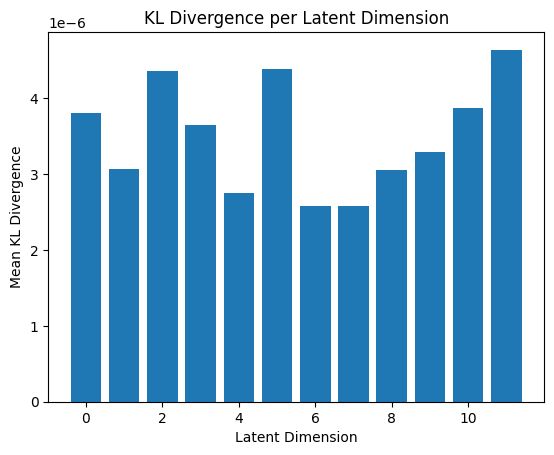

In [169]:


mean_kld_per_dim = np.mean(KLD_per_dim_array, axis=0)  # Shape: [latent_dim]

plt.bar(range(len(mean_kld_per_dim)), mean_kld_per_dim)
plt.xlabel("Latent Dimension")
plt.ylabel("Mean KL Divergence")
plt.title("KL Divergence per Latent Dimension")
plt.show()

In [77]:
print("mu stats:", np.mean(all_means_array), np.var(all_means_array))
print("logvar stats:", np.mean(all_logvar_array), np.var(all_logvar_array))

mu stats: 2.2454167e-06 1.5023193e-07


NameError: name 'all_logvar_array' is not defined

NameError: name 'all_logvar_array' is not defined

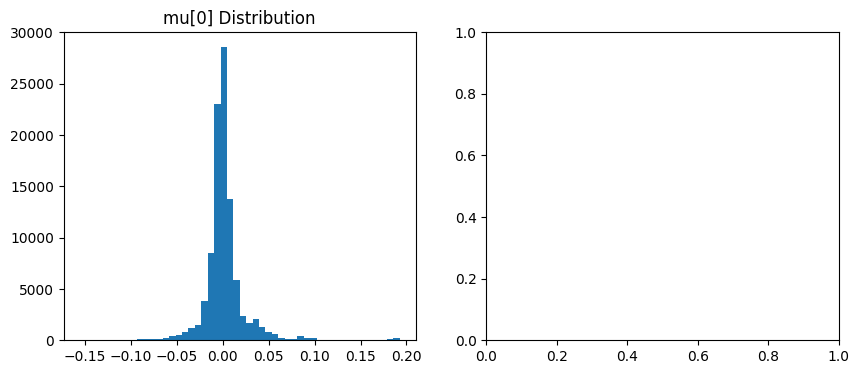

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(all_means_array[:, 0], bins=50)
plt.title("mu[0] Distribution")
plt.subplot(1, 2, 2)
plt.hist(all_logvar_array[:, 0], bins=50)
plt.title("logvar[0] Distribution")
plt.show()

In [127]:
variances = np.var(all_means_array, axis=0)
active_dims = np.sum(variances > 1e-4)  # Dimensions with non-negligible variance
print(f"Active Dimensions: {active_dims}")

Active Dimensions: 10


In [128]:
from skdim.id import TwoNN

# Estimate ID using TwoNN
estimator = TwoNN()
id_estimate = estimator.fit(all_means_array).dimension_
optimal_dims = int(np.round(id_estimate))
print(f"TwoNN Estimate: {optimal_dims}")

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

## Looper

Loop over different number of latent dimensions  


In [ ]:
# Define the list of latent dimensions you want to explore
latent_dims_list = [2, 4, 8, 16]  # Example list, adjust as needed

# Early stopping parameters
patience = 50  # Number of epochs to wait before stopping
min_delta = 0.001  # Minimum change to qualify as improvement


# Create report directory with timestamp
report_dir = Path(f'../reports/cvae_results')
report_dir.mkdir(parents=True, exist_ok=True)

# Initialize results list
results = []

for latent_dim in latent_dims_list:
    print(f"\n=== Training with latent_dim: {latent_dim} ===")
    
    # Create latent dimension-specific directory
    latent_dir = report_dir / f'latent_{latent_dim}d'
    latent_dir.mkdir(exist_ok=True)
    
    # Initialize model and optimizer for current latent dimension
    model = FixedCVAE(input_dim, latent_dim, cond_dim).to(device)
    
    # Reset loss tracking for each latent dimension
    training_loss_values = []
    testing_loss_values = []
    testing_KLD_values = []
    test_recon_values = []
    
    best_recon = float('inf')
    patience_counter = 0

    training_metrics = {
        'epoch': [],
        'train_loss': [],
        'test_loss': [],
        'KLD': [],
        'recon_loss': [],
        'beta': []
    }

    
    # Configure schedulers
    beta_start = 0.3  # Start stronger to prevent early KLD explosion
    beta_end = 0.1    # Gradually relax regularization
    warmup_epochs = 200  # Ramp down beta over this period

    # Learning rate scheduler
    base_lr = 1e-6
    max_lr = 1e-5
    lr_decay_start = 400  # Start reducing LR after this epoch

    optimizer = torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=1e-4)
    

    
    # Training loop for current latent dimension
    for epoch in range(2000):  # Keep 2000 as max epochs
        model.train()
        epoch_loss = 0
        

         # Simple linear schedulers
        if epoch < warmup_epochs:
            beta = beta_start - (beta_start - beta_end) * (epoch / warmup_epochs)
        else:
            beta = beta_end

        # Learning rate warmup + decay
        if epoch < lr_decay_start:
            lr = base_lr + (max_lr - base_lr) * (epoch / lr_decay_start)
        else:
            lr = max_lr * 0.5 ** ((epoch - lr_decay_start) / 500)
            
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        # Add to validation
        
        # Training phase
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            recon_batch, mu, log_var = model(X_batch, y_batch)
            loss = loss_function(recon_batch, X_batch, mu, log_var, beta=beta)
            
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Store training loss
        epoch_loss /= len(train_loader)
        training_loss_values.append(epoch_loss)

        # Testing phase
        model.eval()
        test_loss, KLD_loss, rec_loss = 0, 0, 0
        latent_vars = []
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                recon_test, mu_test, log_var_test = model(X_batch, y_batch)
                test_loss += loss_function(recon_test, X_batch, mu_test, log_var_test, beta=beta).item()
                KLD_loss += KL_div(recon_test, X_batch, mu_test, log_var_test).item()
                rec_loss += recon_loss(recon_test, X_batch).item()

                # Store latent variances (full test set)
                latent_vars.append(torch.exp(log_var))

        # Calculate averages
        test_loss /= len(test_loader)
        current_KLD = KLD_loss / len(test_loader)
        rec_loss /= len(test_loader)

        # Store test metrics
        testing_loss_values.append(test_loss)
        testing_KLD_values.append(current_KLD)
        test_recon_values.append(rec_loss)

        #Early stopping check (RECON-BASED)
        if rec_loss < (best_recon - min_delta):
            best_recon = rec_loss
            patience_counter = 0
            torch.save(model.state_dict(), latent_dir / 'best_model.pth')
        else:
            patience_counter += 1


        # Print progress
        if epoch % 10 == 0:
            raw_KLD = current_KLD / beta if beta != 0 else current_KLD
            KLD_ratio = (raw_KLD / (current_KLD + rec_loss)) * 100
            print(f"Latent: {latent_dim} | Epoch: {epoch} | Train Loss: {epoch_loss:.3e} | Test Loss: {test_loss:.3e} | KLD: {current_KLD:.3e} | Patience: {patience_counter}/{patience}")

        # Early stopping condition
        if patience_counter >= patience:
            print(f"Stopped: Recon plateau at {rec_loss:.3e} (Δ{min_delta:.1e})")
            break

        latent_var = torch.exp(torch.cat(latent_vars)).mean().item()
        if latent_var < 0.05 and epoch > 100:
            print("Latent collapse detected - stopping!")
            break

        if current_KLD < 1e-4:  # Adjusted for XPS scale
            print("KL Collapse Warning!")
            break
        
        epoch_avg_loss = epoch_loss / len(train_loader)
        training_metrics['train_loss'].append(epoch_avg_loss)

        training_metrics['epoch'].append(epoch)
        training_metrics['test_loss'].append(test_loss)
        training_metrics['KLD'].append(current_KLD)
        training_metrics['recon_loss'].append(rec_loss)
        training_metrics['beta'].append(beta)
        
        

    # After training completes for this latent dimension:
    print(f"Completed training for latent_dim {latent_dim}")
    # 2. Save training curves

    pd.DataFrame(training_metrics).to_csv(latent_dir / 'training_metrics.csv', index=False)
    
    # 3. Save final metrics
    final_metrics = {
        'latent_dim': latent_dim,
        'final_train_loss': training_metrics['train_loss'][-1],
        'final_test_loss': training_metrics['test_loss'][-1],
        'final_KLD': training_metrics['KLD'][-1],
        'final_recon_loss': training_metrics['recon_loss'][-1],
        'stopped_epoch': epoch
    }
    results.append(final_metrics)

# Save comprehensive results
results_df = pd.DataFrame(results)
results_df.to_csv(report_dir / 'summary.csv', index=False)

# Note: You'll need to implement saving/loading logic and metric tracking
# across different latent dimensions based on your specific needs


=== Training with latent_dim: 2 ===
Latent: 2 | Epoch: 0 | Train Loss: 2.171e+05 | Test Loss: 1.962e+05 | KLD: 1.895e+01 | Patience: 0/50
Latent: 2 | Epoch: 10 | Train Loss: 2.537e+04 | Test Loss: 1.314e+04 | KLD: 6.080e+02 | Patience: 0/50
Latent: 2 | Epoch: 20 | Train Loss: 1.914e+03 | Test Loss: 8.772e+02 | KLD: 6.006e+02 | Patience: 0/50
Latent: 2 | Epoch: 30 | Train Loss: 1.637e+02 | Test Loss: 7.845e+01 | KLD: 1.423e+02 | Patience: 0/50
Latent: 2 | Epoch: 40 | Train Loss: 9.911e+00 | Test Loss: 2.784e+00 | KLD: 6.721e-01 | Patience: 0/50
Latent: 2 | Epoch: 50 | Train Loss: 1.346e+00 | Test Loss: 7.864e-01 | KLD: 1.107e-01 | Patience: 0/50
Latent: 2 | Epoch: 60 | Train Loss: 6.307e-01 | Test Loss: 6.141e-01 | KLD: 3.704e-02 | Patience: 0/50
Latent: 2 | Epoch: 70 | Train Loss: 5.072e-01 | Test Loss: 5.499e-01 | KLD: 1.675e-02 | Patience: 2/50
Latent: 2 | Epoch: 80 | Train Loss: 4.605e-01 | Test Loss: 4.996e-01 | KLD: 6.151e-03 | Patience: 0/50
Latent: 2 | Epoch: 90 | Train Loss: 4

KeyboardInterrupt: 

## Alternative loss functions:

In [ ]:
def cross_correlation_loss(recon_x, x):
    # Compute FFT of both signals
    recon_x_fft = torch.fft.fft(recon_x, dim=1)
    x_fft = torch.fft.fft(x, dim=1)
    cross_corr = torch.fft.ifft(recon_x_fft * torch.conj(x_fft), dim=1).real
    max_corr = torch.max(cross_corr, dim=1)[0]
    return torch.mean(1 - max_corr)

def loss_function(recon_x, x, mu, log_var, alpha=0, beta=1):
    # Cross-correlation loss (shape alignment)
    REC_CC = cross_correlation_loss(recon_x, x)
    
    # MSE loss (intensity matching)
    REC_MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    
    # KL divergence
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    
    # Weighted sum
    return alpha * REC_CC + beta * REC_MSE + KLD

In [ ]:
def cross_correlation_loss(recon_x, x):
    # Normalize inputs to avoid amplitude biases
    recon_x = (recon_x - recon_x.mean(dim=1, keepdim=True)) / (recon_x.std(dim=1, keepdim=True) + 1e-8)
    x = (x - x.mean(dim=1, keepdim=True)) / (x.std(dim=1, keepdim=True) + 1e-8)

    # Compute FFTs
    recon_x_fft = torch.fft.fft(recon_x, dim=1)
    x_fft = torch.fft.fft(x, dim=1)

    # Compute cross-correlation via inverse FFT
    cross_corr = torch.fft.ifft(recon_x_fft * torch.conj(x_fft), dim=1).real

    # Find the best alignment (max correlation)
    best_shift = torch.argmax(cross_corr, dim=1)
    max_corr = cross_corr.gather(1, best_shift.unsqueeze(1)).squeeze(1)

    return torch.mean(1 - max_corr)

def loss_function(recon_x, x, mu, log_var, alpha=1.0, beta=1.0):
    REC_CC = cross_correlation_loss(recon_x, x)
    REC_MSE = nn.functional.mse_loss(recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    # Normalize loss components to avoid dominance by one term
    REC_CC = REC_CC / (REC_CC.detach().abs().mean() + 1e-8)
    REC_MSE = REC_MSE / (REC_MSE.detach().abs().mean() + 1e-8)

    return alpha * REC_CC + beta * REC_MSE + KLD

In [ ]:
import geomloss

def optimal_transport_loss(recon_x, x, reg=0.01):
    """
    Computes the Sinkhorn distance (Optimal Transport) between reconstructed and true spectra.
    :param recon_x: Reconstructed spectrum (batch, n_points)
    :param x: Ground truth spectrum (batch, n_points)
    :param reg: Entropic regularization parameter
    :return: Sinkhorn loss
    """
    # Ensure the spectra are normalized as probability distributions (sum to 1)
    recon_x = recon_x / (recon_x.sum(dim=1, keepdim=True) + 1e-8)
    x = x / (x.sum(dim=1, keepdim=True) + 1e-8)

    # Compute the Sinkhorn OT distance
    sinkhorn_loss = geomloss.SamplesLoss(loss="sinkhorn", p=1, blur=reg)
    return sinkhorn_loss(recon_x, x)

def loss_function(recon_x, x, mu, log_var, alpha=1.0, beta=1.0):
    """
    VAE loss with Optimal Transport-based reconstruction loss.
    """
    REC_OT = optimal_transport_loss(recon_x, x)
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return alpha * REC_OT + beta * KLD


In [ ]:
import torch.nn.functional as F

def align_spectra(recon_x, x, shift_range=max_shift_index):
    """
    Aligns spectra by shifting the reconstructed spectrum within a small range
    and choosing the best alignment based on cross-correlation.
    
    :param recon_x: Reconstructed spectra (batch_size, n_points)
    :param x: Ground truth spectra (batch_size, n_points)
    :param shift_range: Maximum number of bins to shift in either direction
    :return: Best-aligned reconstructed spectra
    """
    batch_size, n_points = x.shape
    best_shifts = torch.zeros(batch_size, dtype=torch.long, device=x.device)
    best_corr = torch.full((batch_size,), float('-inf'), device=x.device)
    
    for shift in range(-shift_range, shift_range + 1):
        if shift < 0:
            shifted_recon_x = F.pad(recon_x[:, :shift], (abs(shift), 0))
        elif shift > 0:
            shifted_recon_x = F.pad(recon_x[:, shift:], (0, shift))
        else:
            shifted_recon_x = recon_x

        # Compute correlation
        corr = torch.sum(shifted_recon_x * x, dim=1)  # Batch-wise dot product
        update_mask = corr > best_corr
        best_corr[update_mask] = corr[update_mask]
        best_shifts[update_mask] = shift

    # Apply best shift to the reconstructed spectra
    aligned_recon_x = torch.zeros_like(recon_x)
    for i in range(batch_size):
        shift = best_shifts[i].item()
        if shift < 0:
            aligned_recon_x[i, :shift] = recon_x[i, abs(shift):]
        elif shift > 0:
            aligned_recon_x[i, shift:] = recon_x[i, :-shift]
        else:
            aligned_recon_x[i] = recon_x[i]

    return aligned_recon_x

def loss_function(recon_x, x, mu, log_var, alpha=1.0, beta=1.0):
    """
    VAE loss with spectral alignment before MSE.
    """
    aligned_recon_x = align_spectra(recon_x, x)
    REC_MSE = nn.functional.mse_loss(aligned_recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    
    return alpha * REC_MSE + beta * KLD


In [ ]:
import torch

def fft_shift_align(recon_x, x):
    # Compute FFT of both signals
    recon_x_fft = torch.fft.fft(recon_x, dim=1)
    x_fft = torch.fft.fft(x, dim=1)

    # Compute cross-correlation in Fourier space
    cross_corr = torch.fft.ifft(recon_x_fft * torch.conj(x_fft), dim=1).real

    # Find optimal shift index
    shift_idx = torch.argmax(cross_corr, dim=1)  # Best shift for each batch element

    # Apply shift (roll spectra accordingly)
    aligned_recon_x = torch.roll(recon_x, shifts=shift_idx.tolist(), dims=1)
    return aligned_recon_x

def loss_function(recon_x, x, mu, log_var, alpha=1.0, beta=1.0):
    """
    VAE loss with spectral alignment before MSE.
    """
    aligned_recon_x = align_spectra(recon_x, x)
    REC_MSE = nn.functional.mse_loss(aligned_recon_x, x, reduction='mean')
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    
    return alpha * REC_MSE + beta * KLD
